Marta Xiulan Aribó Herrera and German Anashkin

Data Driven Social Analytics - Assignment II

MIIS 2025

---



# Installs and Libraries

In [10]:
import pandas as pd
import snap
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

import datetime
import os
import seaborn as sns
from tqdm import tqdm
import networkx as nx


In [37]:
sns.set_context("paper")

# Download Data (Do not run)

In [55]:
!wget http://www.sociopatterns.org/files/datasets/004/sg_infectious_contact_list.tgz

--2025-01-29 21:45:36--  http://www.sociopatterns.org/files/datasets/004/sg_infectious_contact_list.tgz
S'està resolent www.sociopatterns.org (www.sociopatterns.org)… 95.174.14.229, 2001:4b78:2100::151:1
S'està connectant a www.sociopatterns.org (www.sociopatterns.org)|95.174.14.229|:80… conectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta… 200 OK
Mida: 1425682 (1,4M) [application/x-gzip]
S'està desant a: ‘sg_infectious_contact_list.tgz’

sg_infectious_conta 100%[===================>]   1,36M   302KB/s    in 6,2s    

2025-01-29 21:45:43 (223 KB/s) - s'ha desat ‘sg_infectious_contact_list.tgz’ [1425682/1425682]



In [ ]:
!mkdir -p ../sociopatterns
!tar -xzf sg_infectious_contact_list.tgz -C ../sociopatterns
!ls ../sociopatterns

In [80]:

dataset = pd.DataFrame()
read_path = "../sociopatterns/"
save_path = "../data/"
for file in os.listdir(read_path):
  file = read_path + file
  df = pd.read_csv(file, delimiter='\t')
  df.columns = ['contact_time', 'user_1', 'user_2']
  dataset = pd.concat([dataset, df])

dataset.to_csv(save_path+"infectious_data.csv", index=False)

# Data

## 1. General Characteristics of the Dataset

[DATASET LINK:  Infectious SocioPatterns dynamic contact networks ](href="http://www.sociopatterns.org/datasets/infectious-sociopatterns-dynamic-contact-networks/")

This dataset records face-to-face interactions between individuals overt time. It is structure into three columns: *user_1*, *user_2* and *contact_time*. Each row represents a recorded contact event between two individuals at a specific time. These names have been labeled by us for better understanding.

* *user_1* and *user_2* : Unique and anonymous identifiers assigned to individuals involved in a contact event.
* *contact_time* :  A timestamp representing the time interval [t-20s, t] during which the two individuals were in contact. The time is expressed in UNIX ctime format.

The dataset have shape of 415843 x 3

In [27]:
path = "../data/infectious_data.csv"

dataset_df = pd.read_csv(path)
dataset_df.head()

,contact_time,user_1,user_2
0,1244110759,90505314,78184522
1,1244110759,90505314,78446676
2,1244110759,90505314,78577729
3,1244110759,78184522,75104339
4,1244110759,78446676,74973244


In [28]:
# UTC time to local time
dataset_df['contact_time'] = dataset_df['contact_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))

### 1.1 Face-to-face contact distribution per day

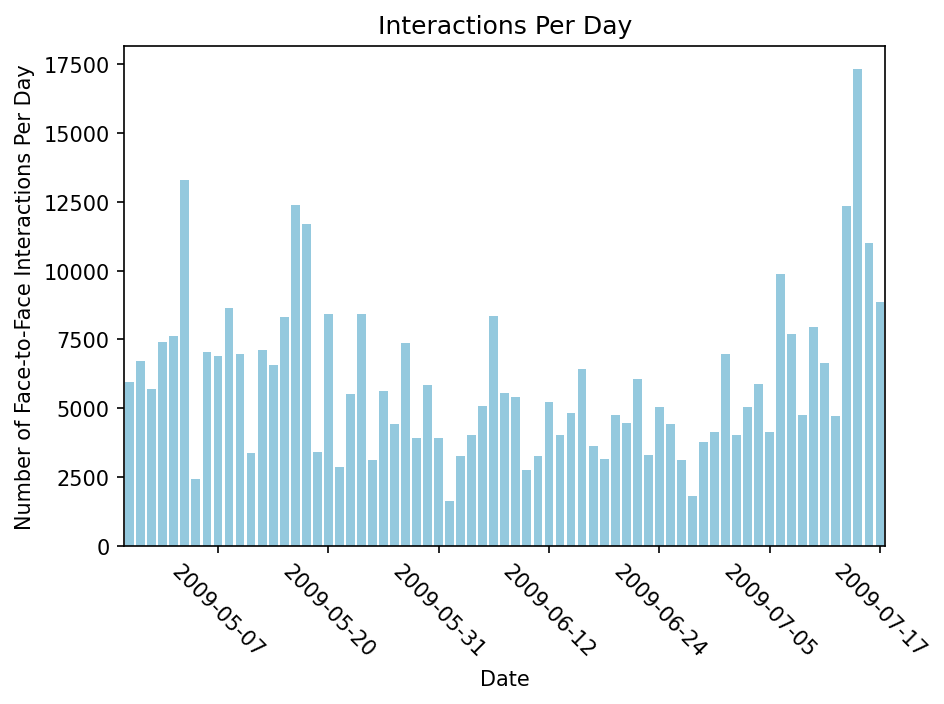

In [25]:
df = dataset_df.copy()

df['date'] = df['contact_time'].dt.date

contact_counts = df.groupby('date').size()

plt.figure(dpi=150)
sns.barplot(contact_counts, color='skyblue')

plt.xlabel('Date')
plt.ylabel('Number of Face-to-Face Interactions Per Day')
plt.title('Interactions Per Day')

plt.xticks(rotation=-45)


plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10)) 

plt.tight_layout() 
plt.show()


## 1.2 Graph

In [6]:
G = snap.TUNGraph.New()

for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
    if not G.IsNode(row['user_1']):
        G.AddNode(row['user_1'])

    if not G.IsNode(row['user_2']):
        G.AddNode(row['user_2'])

    G.AddEdge(row['user_1'], row['user_2'])

print(f"Graph has {G.GetNodes()} nodes and {G.GetEdges()} edges.")

  0%|          | 0/415843 [00:00<?, ?it/s]

100%|██████████| 415843/415843 [00:58<00:00, 7128.70it/s] 

/n Graph has 10972 nodes and 44516 edges.


In [60]:
snap.DrawGViz(G, snap.gvlDot, "G.png", "G", True)

<snap.PUNGraph; proxy of <Swig Object of type 'PUNGraph *' at 0x7049110f1990> >

## b. Node Centrality
Refers to the importance of a node given a graph, how central is the node related to the network. We are going to be measuring this metric using at least three different methods. [Snap doc.](href="https://snap.stanford.edu/snappy/doc/reference/centr.html")

### Degree Centrality
A graph method for undirected graphs that returns degree centrality of a given node NId. Degree centrality of a node is defined as its degree/(N-1), where N is the number of nodes in the graph.

In [40]:
degree_centrality = {}
for node in G.Nodes():
    degree_centrality[node.GetId()] = G.GetNI(node.GetId()).GetDeg()

top_5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 nodes by Degree Centrality:")
for node, centrality in top_5_degree:
    print(f"Node {node} - Degree Centrality: {centrality}")
    print(df[df['user_1'] == node]['user_1'].count())
    print(df[df['user_1'] == node]['date'].value_counts())



Top 5 nodes by Degree Centrality:
Node 83558448 - Degree Centrality: 64
171
date
2009-05-17    171
Name: count, dtype: int64
Node 90636462 - Degree Centrality: 50
51
date
2009-07-15    51
Name: count, dtype: int64
Node 94961689 - Degree Centrality: 48
56
date
2009-07-14    56
Name: count, dtype: int64
Node 81068077 - Degree Centrality: 47
32
date
2009-07-15    32
Name: count, dtype: int64
Node 80150715 - Degree Centrality: 46
196
date
2009-07-14    196
Name: count, dtype: int64
